In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
# tqdm().pandas()
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
# restructure the model
# model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# # summarize
# print(base_model.summary())

In [ ]:
BASE_DIR='./archive'

In [ ]:
# extracting features individually with image number as key

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     image = preprocess_input(image)
    # extract features
    feature = base_model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# store features in pickle
import pickle
pickle.dump(features, open(os.path.join('./archive', 'features_with_keys.pkl'), 'wb'))

In [2]:
import pandas as pd
features = pd.read_pickle(r'./archive/features_with_keys.pkl')

In [3]:
# flattening the features obtained

flattened_features_dict = {}
for key, value in features.items():
    flatten_layer = tf.keras.layers.Flatten()
    flattened_features_dict[key] = flatten_layer(np.array(value))

In [4]:
for i in list(flattened_features_dict.values())[0]:
    print(i.shape)
len(features)

(62720,)


8091

In [2]:
# reading captions

BASE_DIR='./archive/'
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [3]:
# create mapping of image to captions

mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [4]:
len(mapping)

8091

In [5]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [6]:
# preprocess the text
clean(mapping)

In [7]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [8]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [9]:
len(all_captions)

40455

In [11]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [12]:
vocab_size

8485

In [13]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [30]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    flatten_layer = tf.keras.layers.Flatten()
#                     flattened_feature = flatten_layer(features[key])
#                     X1.append(flattened_feature[key][0])
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
#                     print(len(X1[0]))
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [19]:
# encoder model
# image feature layers
inputs1 = Input(shape=(62720))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
# plot_model(model, show_shapes=True)

In [18]:
from keras.models import load_model
model=load_model("./best_model_copy.h5")
print(model)

In [24]:
# train the model
epochs = 3
batch_size = 32
steps = len(train) // batch_size

for i in tqdm(range(epochs)):
    # create data generator
    generator = data_generator(train, mapping, flattened_features_dict, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/3 [00:00<?, ?it/s]

227/227 [==============================] - 872s 4s/step - loss: 2.3631


In [25]:
model.save('best_model_copy.h5')

In [26]:
# Epoch counter
# 20

In [14]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [15]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [52]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, flattened_features_dict[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(1/3, 1/3, 1/3, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.542215
BLEU-2: 0.314758
BLEU-3: 0.188766
BLEU-4: 0.109790


In [53]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, flattened_features_dict[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing on the beach endseq


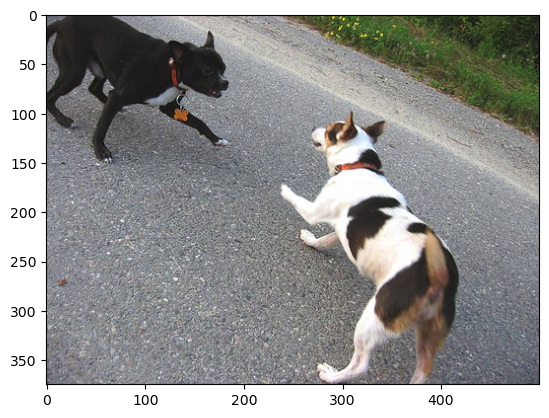

In [54]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq girl is painting on fingerpaints endseq


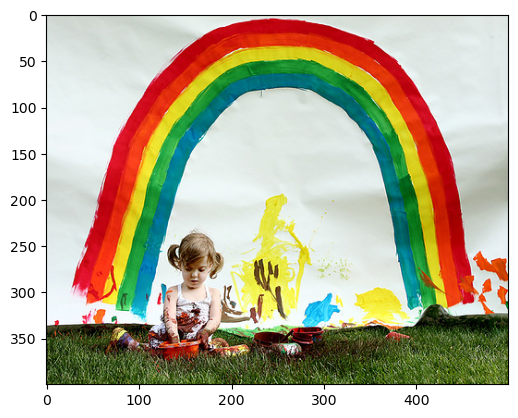

In [55]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man in horned coat displaying pictures in the snow endseq


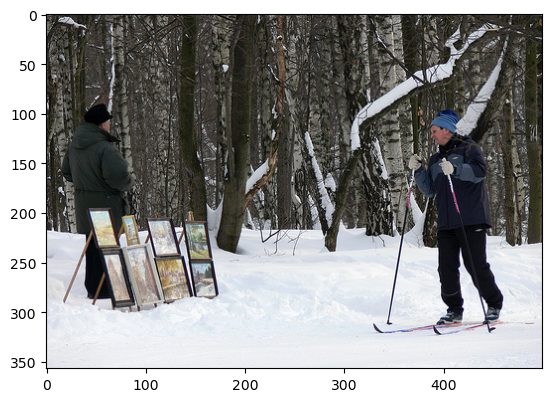

In [56]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption_new(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_name)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
#     image = preprocess_input(image)
    # extract features
    feature = base_model.predict(image, verbose=0)
    # get image ID
#     image_id = img_name.split('.')[0]
    # store feature
#     features[image_id] = feature
    image = Image.open(img_path)
#     captions = mapping[image_id]
#     print('---------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
    # predict the caption
    flattened_features_dict = {}
#     for key, value in feature:
#         flatten_layer = tf.keras.layers.Flatten()
#         flattened_features_dict[key] = flatten_layer(np.array(value))
    flatten_layer=tf.keras.layers.Flatten()
    new_feature=flatten_layer(np.array(feature))
#     print(new_feature.shape)
#     print(feature.shape)
    y_pred = predict_caption(model, new_feature, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq the man is standing on the beach with the sun and other people endseq


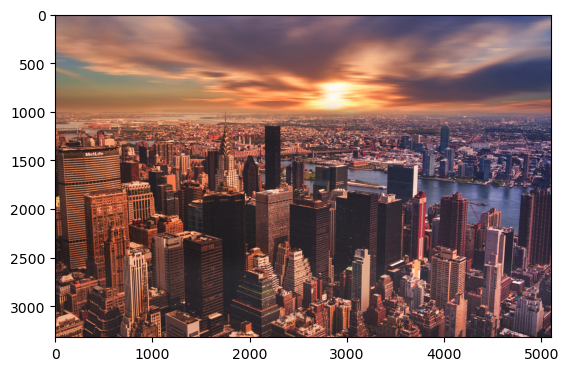

In [19]:
generate_caption_new('pexels-quintin-gellar-313782.jpg')

---------------------Actual---------------------
(1, 62720)
(1, 7, 7, 1280)
--------------------Predicted--------------------
startseq the man is sitting on the sidewalk next to the window endseq


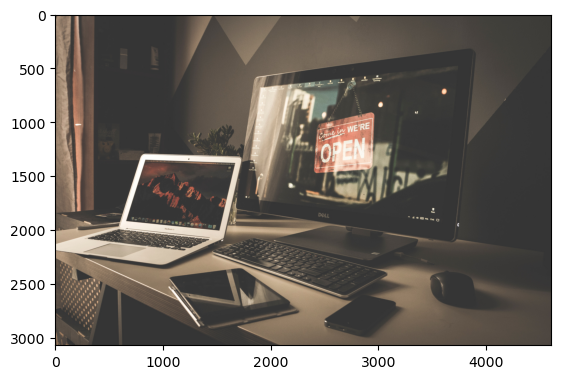

In [32]:
generate_caption_new('pexels-mateusz-dach-450035.jpg')

---------------------Actual---------------------
(1, 62720)
(1, 7, 7, 1280)
--------------------Predicted--------------------
startseq blue bird is in the water with blue blue and blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue blue and


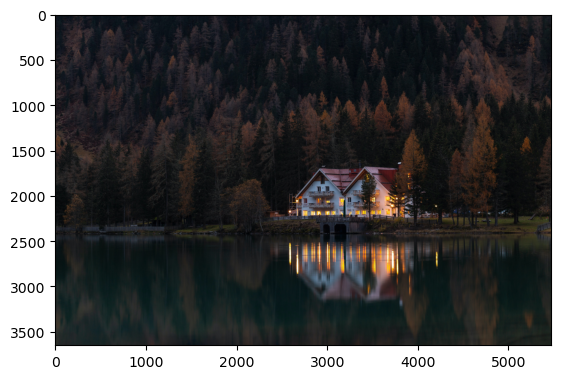

In [33]:
generate_caption_new('pexels-eberhard-grossgasteiger-1612351.jpg')

--------------------Predicted--------------------
startseq the man in the white shirt is throwing the ball endseq


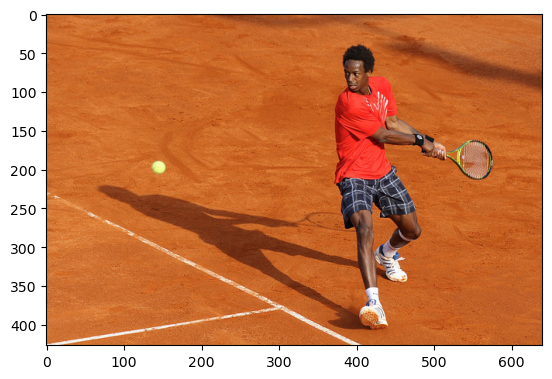

In [20]:
generate_caption_new('000000000057.jpg')

--------------------Predicted--------------------
startseq woman in pink shirt is jumping up to treats in the air endseq


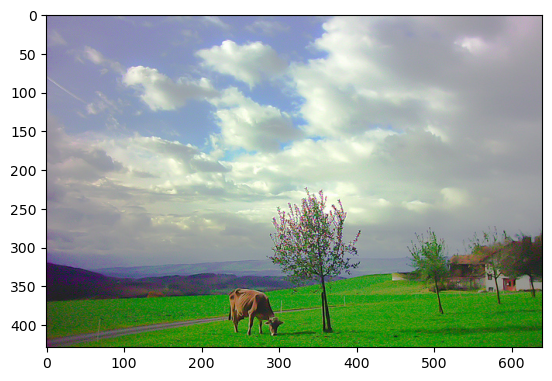

In [22]:
generate_caption_new('000000000090.jpg')